Final Project
Train a DP model using PATE method on MNIST dataset

Steps:
1. Loading the MNIST data
2. Create Data Loader for teacher classifier
3. Visualize the batch of training data
4. Define Network Architecture
5. Training num_teacher Classifier models
6. Creating public dataset and student loader
7. Predict labels for a Dataset
8. Creating the Aggregated Teacher and Student Labels
9. Creating Student Model and Training it with the Label generated from last step
10. Installing and Importing Pysyft

In [5]:
#Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset

In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
#Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [7]:
#Download datasets
train_set = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = True, transform=transform)
test_set = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = False, transform=transform)

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle = True)
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\Vilas/.pytorch/MNIST_data/
    Split: Train


In [9]:
#Creating Data Loader for teacher classifier
#Divide the training datasets into 'num-teacher' as teacher datasets and load them into trainloaders
num_teachers = 100

teacher_loaders = [] #list of dataloaders
    
data_size = len(train_set) // num_teachers
    
for i in range(num_teachers):
    indices = list(range(i * data_size, (i+1) * data_size)) #creating subsets of 600 datasize
    subset = Subset(train_set, indices)
    loader = torch.utils.data.DataLoader(subset, batch_size = 32)
    teacher_loaders.append(loader)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Active device:", device)

Active device: cpu


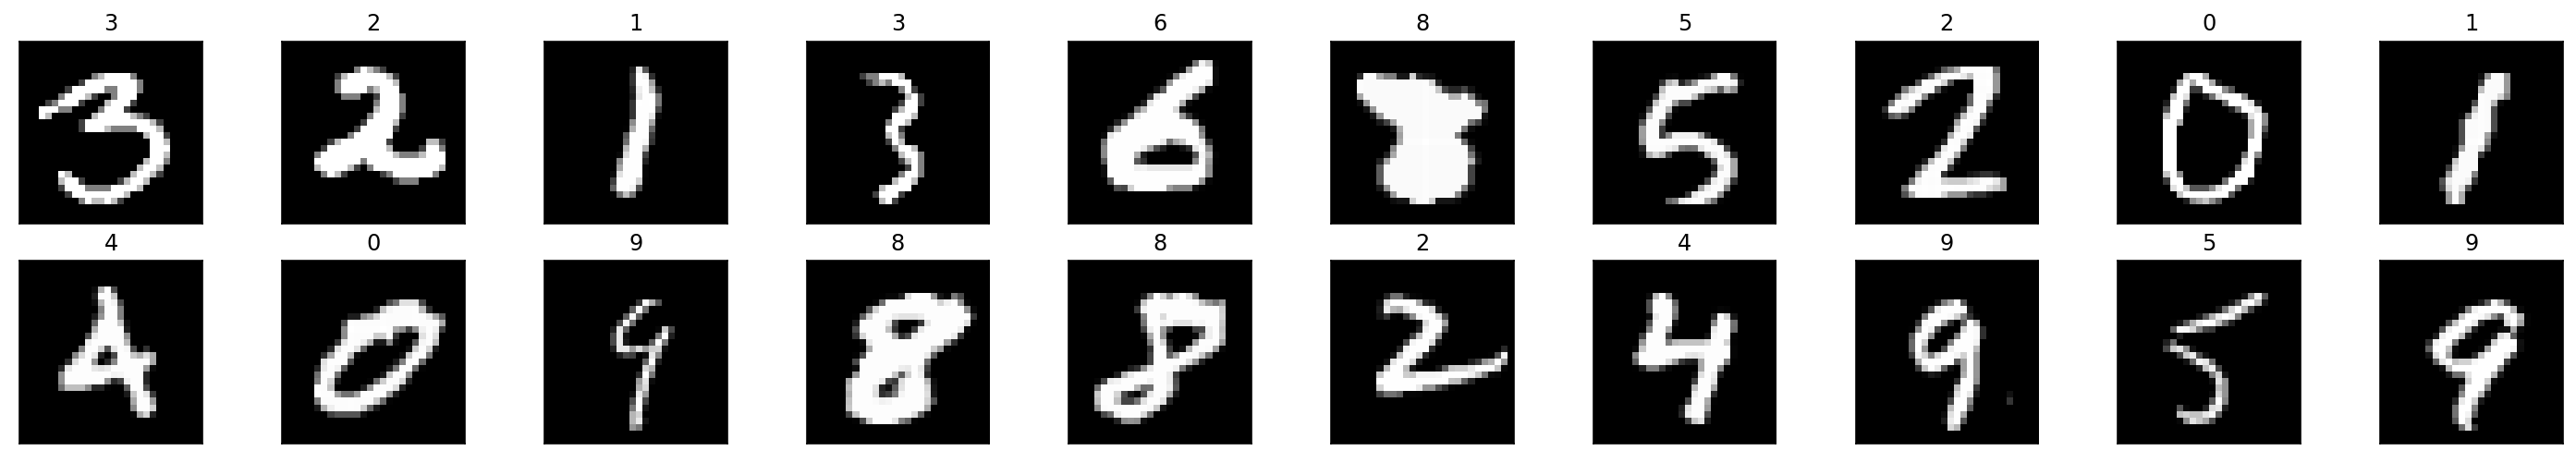

In [11]:
#Visualize a Batch of Training Data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [12]:
#Network Architecture
# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 64
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [15]:
#Training num_teachers Classifier models
epochs = 10
models =[]
for i in range(num_teachers):
    model = Net()
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    running_loss = 0
    teacher_loss = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in teacher_loaders[i]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    teacher_loss.append(running_loss)
    
    print("Training teacher = {}/{}..".format(i+1, num_teachers), "Training Loss: {:.3f}..".format(running_loss))
    models.append(model)

Training teacher = 1/100.. Training Loss: 17.081..
Training teacher = 2/100.. Training Loss: 18.785..
Training teacher = 3/100.. Training Loss: 16.637..
Training teacher = 4/100.. Training Loss: 16.141..
Training teacher = 5/100.. Training Loss: 17.070..
Training teacher = 6/100.. Training Loss: 16.929..
Training teacher = 7/100.. Training Loss: 16.202..
Training teacher = 8/100.. Training Loss: 17.843..
Training teacher = 9/100.. Training Loss: 17.595..
Training teacher = 10/100.. Training Loss: 17.361..
Training teacher = 11/100.. Training Loss: 15.367..
Training teacher = 12/100.. Training Loss: 18.025..
Training teacher = 13/100.. Training Loss: 20.098..
Training teacher = 14/100.. Training Loss: 17.266..
Training teacher = 15/100.. Training Loss: 18.841..
Training teacher = 16/100.. Training Loss: 16.923..
Training teacher = 17/100.. Training Loss: 16.423..
Training teacher = 18/100.. Training Loss: 15.883..
Training teacher = 19/100.. Training Loss: 16.203..
Training teacher = 20

In [16]:
#Creating publis dataset and student loader
student_train = Subset(test_set, list(range(9000))) #allocate 90% of test data as training data
student_test = Subset(test_set, list(range(9000, 10000))) #10% of test data as testing data

In [17]:
#Creating student loaders
student_trainloader = torch.utils.data.DataLoader(student_train, batch_size=64, shuffle=True)
student_testloader = torch.utils.data.DataLoader(student_test, batch_size=64, shuffle=True)

In [18]:
#Predict labels for a dataset
def predict(model, dataloader):
    '''Predict labels for a dataset. Input: model and dataloader'''
    outputs = torch.zeros(0, dtype=torch.long).to(device)
    model.to(device)
    model.eval()
    for image, labels in dataloader:
        image, labels = image.to(device), labels.to(device)
        output = model(image)
        ps = torch.argmax(torch.exp(output), dim=1)
        outputs = torch.cat((outputs, ps))
    return outputs

In [20]:
#Creating the Aggregated Teacher and Student Labels by combining the predictions of Teacher Models
epsilon = 0.1
preds = torch.zeros((len(models),9000), dtype=torch.long)
for i, model in enumerate(models):
    results = predict(model, student_trainloader)
    preds[i] = results
labels = np.array([]).astype(int)
for image_preds in np.transpose(preds):
    label_counts = np.bincount(image_preds, minlength=10)
    beta = 1/epsilon
    for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1)
    new_label = np.argmax(labels_counts)
    labels = np.append(labels, new_label)

In [21]:
student_labels = np.array(labels)
preds = preds.numpy()

In [23]:
#Creating student model and training it with label generated from last step
epochs = 50
train_losses, test_losses = [], []
model = Net()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
running_loss = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in student_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in student_testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            train_losses.append(running_loss/len(student_trainloader))
            test_losses.append(test_loss/len(student_testloader))
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Training Loss: {:.3f}..".format(running_loss/len(student_trainloader)),
                  "Test Loss: {:.3f}..".format(test_loss/len(student_testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(student_testloader)))

Epoch: 1/50.. Training Loss: 0.889.. Test Loss: 0.522.. Test Accuracy: 0.846
Epoch: 2/50.. Training Loss: 0.422.. Test Loss: 0.410.. Test Accuracy: 0.873
Epoch: 3/50.. Training Loss: 0.336.. Test Loss: 0.392.. Test Accuracy: 0.889
Epoch: 4/50.. Training Loss: 0.277.. Test Loss: 0.405.. Test Accuracy: 0.884
Epoch: 5/50.. Training Loss: 0.224.. Test Loss: 0.284.. Test Accuracy: 0.908
Epoch: 6/50.. Training Loss: 0.201.. Test Loss: 0.339.. Test Accuracy: 0.909
Epoch: 7/50.. Training Loss: 0.179.. Test Loss: 0.267.. Test Accuracy: 0.924
Epoch: 8/50.. Training Loss: 0.153.. Test Loss: 0.269.. Test Accuracy: 0.931
Epoch: 9/50.. Training Loss: 0.134.. Test Loss: 0.271.. Test Accuracy: 0.925
Epoch: 10/50.. Training Loss: 0.134.. Test Loss: 0.263.. Test Accuracy: 0.923
Epoch: 11/50.. Training Loss: 0.116.. Test Loss: 0.245.. Test Accuracy: 0.928
Epoch: 12/50.. Training Loss: 0.107.. Test Loss: 0.258.. Test Accuracy: 0.927
Epoch: 13/50.. Training Loss: 0.099.. Test Loss: 0.257.. Test Accuracy: 0

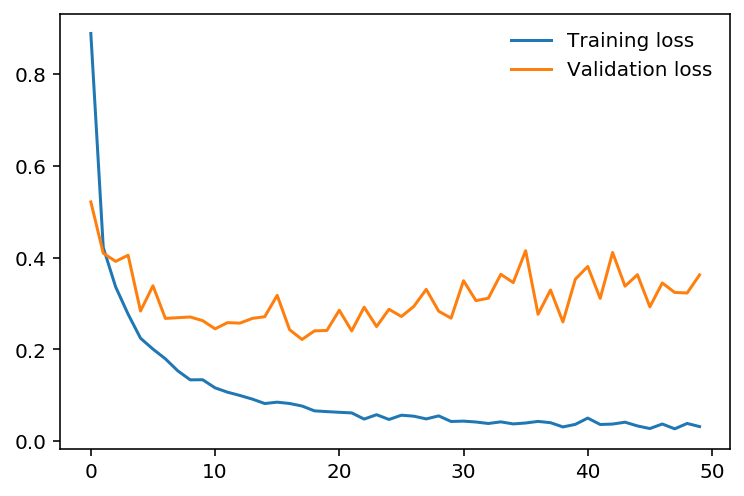

In [24]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [25]:
print("Accuracy obtained: {:.3f}%".format(accuracy/len(student_testloader)*100))

Accuracy obtained: 93.750%


In [26]:
#Installing and Importing Pysyft
from syft.frameworks.torch.differential_privacy import pate

W0727 00:12:54.568265 14164 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'C:\Users\Vilas\Anaconda3\envs\pysyft\lib\site-packages\tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0727 00:12:54.800019 14164 deprecation_wrapper.py:119] From C:\Users\Vilas\Anaconda3\envs\pysyft\lib\site-packages\tf_encrypted\session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [27]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds = preds, indices = student_labels,
                                                  noise_eps=epsilon, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 371.5129254649703
Data Dependent Epsilon: 371.5129254650068
